In [1]:
from astropy.io import fits
import astropy.wcs as wcs
import astropy.units as u
from astropy.convolution import convolve_fft
from astropy.stats import mad_std
import numpy as np
from radio_beam import Beam
from reproject import reproject_interp
from matplotlib import pyplot as plt
from scipy.ndimage import binary_dilation
from astropy.modeling import models, fitting
from astropy.table import Table, vstack 
from glob import glob 
from synphot import SpectralElement, units
from matplotlib.ticker import (MultipleLocator)
import os

import warnings 
warnings.filterwarnings('ignore')

# Loading files

In [2]:
def get_hdu(rootdir, filename, hdu_id=0, return_filename=False):
    filename_full = glob(rootdir+filename)[0]
    if hdu_id == 'all':
        hdu = fits.open(filename_full)
    else:
        hdu = fits.open(filename_full)[hdu_id]
    print(filename_full)

    if return_filename: 
        return(hdu, filename_full)
    else:  
        return(hdu)

galaxy = 'ngc628c'
galaxy_muse = 'ngc0628'
rootdir = '/Users/abarnes/Dropbox/work/Smallprojects/galaxies/data_hstha/%s/' %galaxy
rootdir_bp = '/Users/abarnes/Dropbox/work/Smallprojects/galaxies/data_misc/hst_filters/' 

narrowband_filter = 'f658n'
instrument_f555w  = 'acs'
instrument_f65Xn = 'acs'
instrument_f814w = 'acs'

hdu_muse_f555w  = get_hdu(rootdir, 'muse/%s*_%s_*F555W.fits' %(galaxy_muse.upper(), instrument_f555w.upper()))
hdu_muse_f65Xn  = get_hdu(rootdir, 'muse/%s*_%s_*%s.fits' %(galaxy_muse.upper(), instrument_f65Xn.upper(), narrowband_filter.upper()))
hdu_muse_f814w  = get_hdu(rootdir, 'muse/%s*_%s_*F814W.fits' %(galaxy_muse.upper(), instrument_f814w.upper()))
hdu_muse_stars  = get_hdu(rootdir, 'muse/%s_starmask.fits' %galaxy_muse.upper())
hdu_muse_neb    = get_hdu(rootdir, 'muse/%s_nebmask.fits' %galaxy_muse.upper())
hdu_muse        = get_hdu(rootdir, 'muse/%s*_MAPS.fits' %galaxy_muse.upper(), 'all')

hdu_hst_f555w   = get_hdu(rootdir, 'hst/%s*_%s_*f555w*.fits' %(galaxy, instrument_f555w))
hdu_hst_f65Xn   = get_hdu(rootdir, 'hst/%s*_%s_*%s*.fits' %(galaxy, instrument_f65Xn, narrowband_filter))
hdu_hst_f814w   = get_hdu(rootdir, 'hst/%s*_%s_*f814w*.fits' %(galaxy, instrument_f814w))

hst_res  = 0.07 * u.arcsec
_, file_muse_f65Xn = get_hdu(rootdir, 'muse/%s*_%s_*%s.fits' %(galaxy_muse.upper(), instrument_f65Xn.upper(), narrowband_filter.upper()), return_filename=True)
muse_res = np.float32(file_muse_f65Xn.split('asec')[0].split('-')[-1]) * u.arcsec

/Users/abarnes/Dropbox/work/Smallprojects/galaxies/data_hstha/ngc628c/muse/NGC0628-0.92asec_ACS_F555W.fits
/Users/abarnes/Dropbox/work/Smallprojects/galaxies/data_hstha/ngc628c/muse/NGC0628-0.92asec_ACS_F658N.fits
/Users/abarnes/Dropbox/work/Smallprojects/galaxies/data_hstha/ngc628c/muse/NGC0628-0.92asec_ACS_F814W.fits
/Users/abarnes/Dropbox/work/Smallprojects/galaxies/data_hstha/ngc628c/muse/NGC0628_starmask.fits
/Users/abarnes/Dropbox/work/Smallprojects/galaxies/data_hstha/ngc628c/muse/NGC0628_nebmask.fits
/Users/abarnes/Dropbox/work/Smallprojects/galaxies/data_hstha/ngc628c/muse/NGC0628-0.92asec_MAPS.fits
/Users/abarnes/Dropbox/work/Smallprojects/galaxies/data_hstha/ngc628c/hst/ngc628c_acs_f555w_exp_drc_sci.fits
/Users/abarnes/Dropbox/work/Smallprojects/galaxies/data_hstha/ngc628c/hst/ngc628c_acs_f658n_exp_drc_sci.fits
/Users/abarnes/Dropbox/work/Smallprojects/galaxies/data_hstha/ngc628c/hst/ngc628c_acs_f814w_exp_drc_sci.fits
/Users/abarnes/Dropbox/work/Smallprojects/galaxies/data_h

In [3]:
def make_paths(rootdir):
    
    print('[Info] Outputing to the following:')
    print(rootdir+'hst_contsub_bintests')

    if not os.path.isdir(rootdir+'hst_contsub_bintests'):
        os.mkdir(rootdir+'hst_contsub_bintests')  
    if not os.path.isdir(rootdir+'hst_contsub_bintests/figs'):
        os.mkdir(rootdir+'hst_contsub_bintests/figs')
    os.system('rm -rf '+rootdir+'hst_contsub_bintests/*.fits')

make_paths(rootdir)

[Info] Outputing to the following:
/Users/abarnes/Dropbox/work/Smallprojects/galaxies/data_hstha/ngc628c/hst_contsub_bintests


In [4]:
def get_bandpassinfo(files):

    files.sort()

    bp = {}
    for file in files:

        print(file)

        area = 45238.93416 * units.AREA  # HST
        bp_ = SpectralElement.from_file(file)
        name = file.split('/')[-1].split('.dat')[0].replace('HST_', '').replace('.F', '_F')
        name = name.replace('WFC_', '')
        name = name.replace('WFC3_', '')
        name = name.replace('UVIS1', 'UVIS')

        bp[name] = {'equivwidth': bp_.equivwidth().value, 
                    'integrate': bp_.integrate().value, 
                    'rmswidth': bp_.rmswidth().value, 
                    'photbw': bp_.photbw().value, 
                    'fwhm': bp_.fwhm().value, 
                    'rectwidth': bp_.rectwidth().value, 
                    'pivot': bp_.pivot().value, 
                    'unit_response': bp_.unit_response(area).value}  
    
    return(bp)

files_bp = glob('%s*.dat' %rootdir_bp)
bp = get_bandpassinfo(files_bp)
bp.keys()

/Users/abarnes/Dropbox/work/Smallprojects/galaxies/data_misc/hst_filters/HST_ACS_WFC.F550M.dat
/Users/abarnes/Dropbox/work/Smallprojects/galaxies/data_misc/hst_filters/HST_ACS_WFC.F555W.dat
/Users/abarnes/Dropbox/work/Smallprojects/galaxies/data_misc/hst_filters/HST_ACS_WFC.F658N.dat
/Users/abarnes/Dropbox/work/Smallprojects/galaxies/data_misc/hst_filters/HST_ACS_WFC.F814W.dat
/Users/abarnes/Dropbox/work/Smallprojects/galaxies/data_misc/hst_filters/HST_WFC3_UVIS1.F555W.dat
/Users/abarnes/Dropbox/work/Smallprojects/galaxies/data_misc/hst_filters/HST_WFC3_UVIS1.F657N.dat
/Users/abarnes/Dropbox/work/Smallprojects/galaxies/data_misc/hst_filters/HST_WFC3_UVIS1.F658N.dat
/Users/abarnes/Dropbox/work/Smallprojects/galaxies/data_misc/hst_filters/HST_WFC3_UVIS1.F814W.dat
/Users/abarnes/Dropbox/work/Smallprojects/galaxies/data_misc/hst_filters/HST_WFC3_UVIS2.F547M.dat


dict_keys(['ACS_F550M', 'ACS_F555W', 'ACS_F658N', 'ACS_F814W', 'UVIS_F555W', 'UVIS_F657N', 'UVIS_F658N', 'UVIS_F814W', 'UVIS2_F547M'])

# Correct units 
HST -> electron/s to ergcm2sA 
MUSE - > Jy to ergcm2sA

In [5]:
def get_nanzeros(hdu):
    hdu.data[hdu.data == 0] = np.nan
    return(hdu)

hdu_hst_f555w = get_nanzeros(hdu_hst_f555w)
hdu_hst_f65Xn = get_nanzeros(hdu_hst_f65Xn)
hdu_hst_f814w = get_nanzeros(hdu_hst_f814w)

In [6]:
def get_electrons_2_ergcm2sA(hdu, photflam=None, photplam=None, photbw=None):

    data = hdu.data.copy()

    if photflam == None: 

        # Get the necessary header keywords for scaling and conversion
        photflam = hdu.header['PHOTFLAM']
        photplam = hdu.header['PHOTPLAM']
        photbw = hdu.header['PHOTBW']
    
    # Scale the data using photflam and photbw
    data_conv = data * photflam

    hdu.data = np.array(data_conv, dtype=np.float32) *1e20
    hdu.header['BUNIT'] = ('erg/s/cm2/A/pixel', '1e-20 erg/s/cm2/A')

    return(hdu)

hdu_hst_f555w = get_electrons_2_ergcm2sA(hdu_hst_f555w, bp['%s_%s' %(instrument_f555w.upper(), 'F555W')]['unit_response'])
hdu_hst_f65Xn = get_electrons_2_ergcm2sA(hdu_hst_f65Xn, bp['%s_%s' %(instrument_f65Xn.upper(), narrowband_filter.upper())]['unit_response'])
hdu_hst_f814w = get_electrons_2_ergcm2sA(hdu_hst_f814w, bp['%s_%s' %(instrument_f814w.upper(), 'F814W')]['unit_response'])

In [7]:
def get_Jy_2_ergcm2sA(hdu, photplam):

    data = hdu.data.copy()
    
    w = photplam * u.AA
    a = 1. * u.Jy
    b = a.to(u.erg / u.cm**2 / u.s / u.AA, u.spectral_density(w))
    data_conv = data * b.value

    hdu.data = np.array(data_conv, dtype=np.float32) *1e20
    hdu.header['BUNIT'] = ('erg/s/cm2/A/pixel', '1e-20 erg/s/cm2/A')

    return(hdu)

hdu_muse_f555w = get_Jy_2_ergcm2sA(hdu_muse_f555w, bp['%s_%s' %(instrument_f555w.upper(), 'F555W')]['pivot'])
hdu_muse_f65Xn = get_Jy_2_ergcm2sA(hdu_muse_f65Xn, bp['%s_%s' %(instrument_f65Xn.upper(), narrowband_filter.upper())]['pivot'])
hdu_muse_f814w = get_Jy_2_ergcm2sA(hdu_muse_f814w, bp['%s_%s' %(instrument_f814w.upper(), 'F814W')]['pivot'])

# Smoothing and Regridding
Smoothing and regridding HST to MUSE 

In [8]:
def get_smooth(hdu, initial_resolution, desired_resolution):
    
    # Create a WCS object from the input HDU header
    wcs_ = wcs.WCS(hdu.header)

    # Calculate the pixel scale in degrees
    pixscale = wcs.utils.proj_plane_pixel_area(wcs_.celestial) ** 0.5 * u.deg
    print(f"[INFO] Pixel scale: {pixscale.to('arcsec'):.2f} arcsec")

    # Define the initial and desired beams
    initial_beam = Beam(initial_resolution)
    desired_beam = Beam(desired_resolution)

    print(f"[INFO] Initial Resolution: {initial_resolution.to('arcsec'):.2f} arcsec")
    print(f"[INFO] Desired Resolution: {desired_resolution.to('arcsec'):.2f} arcsec")
    
    # Create the convolution kernel
    convolution_beam = (desired_resolution.to('arcsec')**2 - initial_resolution.to('arcsec')**2)**0.5
    convolution_kernel = desired_beam.deconvolve(initial_beam).as_kernel(pixscale)
    print(f"[INFO] Convolution kernel: {convolution_beam.to('arcsec'):.2f} arcsec")

    # Convolve the image with the kernel to smooth it
    print("[INFO] Performing image convolution...")
    smoothed_data = convolve_fft(hdu.data, convolution_kernel, preserve_nan=True, allow_huge=True)
    print("[INFO] Image convolution complete.")

    output_hdu = fits.PrimaryHDU(np.array(smoothed_data, dtype=np.float32), hdu.header)

    print("[INFO] Smoothing process completed.")
    return(output_hdu)

hdu_hst_f555w_sm = get_smooth(hdu_hst_f555w, hst_res, muse_res)
hdu_hst_f65Xn_sm = get_smooth(hdu_hst_f65Xn, hst_res, muse_res)
hdu_hst_f814w_sm = get_smooth(hdu_hst_f814w, hst_res, muse_res)

[INFO] Pixel scale: 0.04 arcsec arcsec
[INFO] Initial Resolution: 0.07 arcsec arcsec
[INFO] Desired Resolution: 0.92 arcsec arcsec
[INFO] Convolution kernel: 0.92 arcsec arcsec
[INFO] Performing image convolution...
[INFO] Image convolution complete.
[INFO] Smoothing process completed.
[INFO] Pixel scale: 0.04 arcsec arcsec
[INFO] Initial Resolution: 0.07 arcsec arcsec
[INFO] Desired Resolution: 0.92 arcsec arcsec
[INFO] Convolution kernel: 0.92 arcsec arcsec
[INFO] Performing image convolution...
[INFO] Image convolution complete.
[INFO] Smoothing process completed.
[INFO] Pixel scale: 0.04 arcsec arcsec
[INFO] Initial Resolution: 0.07 arcsec arcsec
[INFO] Desired Resolution: 0.92 arcsec arcsec
[INFO] Convolution kernel: 0.92 arcsec arcsec
[INFO] Performing image convolution...
[INFO] Image convolution complete.
[INFO] Smoothing process completed.


In [9]:
def get_regrid(hdu_input, hdu_template, output_filename=None, conserve_flux=True, order='bilinear'):

    print("[INFO] Reprojecting the input image to match the template WCS...")

    # Extract the WCS information from the input and template headers
    wcs_input = wcs.WCS(hdu_input.header)
    wcs_template = wcs.WCS(hdu_template.header)

    # Calculate the pixel scale for input and template images
    pixscale_input = wcs.utils.proj_plane_pixel_area(wcs_input.celestial)
    pixscale_template = wcs.utils.proj_plane_pixel_area(wcs_template.celestial)

    # Reproject the input image to match the template WCS
    print("[INFO] Performing image reprojection...")
    # data_output = reproject_interp(hdu_input, hdu_template.header, order=0, parallel=True)[0]
    # data_output = reproject_interp(hdu_input, hdu_template.header, order=0)[0]
    data_output = reproject_interp(hdu_input, hdu_template.header, order=order)[0]
    hdu_output = fits.PrimaryHDU(data_output, hdu_template.header)
    print("[INFO] Image reprojection complete.")

    if conserve_flux:
        # Scale the output data to conserve flux 
        print(f"[INFO] Scaling the output data to conserve flux with factor {(pixscale_template / pixscale_input):.2f}")
        hdu_output.data = hdu_output.data * (pixscale_template / pixscale_input)
        hdu_output.data = np.array(hdu_output.data, dtype=np.float32)
        print("[INFO] Flux scaling complete.")

    print("[INFO] Reprojection process completed.")
    return(hdu_output)

hdu_hst_f555w_smre = get_regrid(hdu_hst_f555w_sm, hdu_muse_f555w)
hdu_hst_f65Xn_smre = get_regrid(hdu_hst_f65Xn_sm, hdu_muse_f65Xn)
hdu_hst_f814w_smre = get_regrid(hdu_hst_f814w_sm, hdu_muse_f814w)

[INFO] Reprojecting the input image to match the template WCS...
[INFO] Performing image reprojection...
[INFO] Image reprojection complete.
[INFO] Scaling the output data to conserve flux with factor 25.48
[INFO] Flux scaling complete.
[INFO] Reprojection process completed.
[INFO] Reprojecting the input image to match the template WCS...
[INFO] Performing image reprojection...
[INFO] Image reprojection complete.
[INFO] Scaling the output data to conserve flux with factor 25.48
[INFO] Flux scaling complete.
[INFO] Reprojection process completed.
[INFO] Reprojecting the input image to match the template WCS...
[INFO] Performing image reprojection...
[INFO] Image reprojection complete.
[INFO] Scaling the output data to conserve flux with factor 25.48
[INFO] Flux scaling complete.
[INFO] Reprojection process completed.


# Flux scaling
Scaling flux of HST to MUSE with linear fits

In [19]:
def get_bins(data1, data2, num_bins, min_val=None, max_val=None, equal_spaced=True):

    # Calculate min and max if not provided
    if min_val is None:
        min_val = np.nanmin(data1)
    if max_val is None:
        max_val = np.nanmax(data1)

    # Generate bin edges
    # for equal_spaced bins = space spacing
    if equal_spaced:
        bin_edges = np.linspace(min_val, max_val, num_bins + 1)
    # for equal_number bins = same number of points
    else: 
        percentiles = np.linspace(0, 100, num_bins+1)
        bin_edges = np.percentile(data1, percentiles)

    # Calculate mean values within each bin
    binned_values1 = np.zeros(num_bins)
    binned_values2 = np.zeros(num_bins)

    for i in range(num_bins):

        bin_mask = ((data1>=bin_edges[i]) & (data1<=bin_edges[i+1]))
        # bin_mask = (data1>=bin_edges[i])
        bin_ids = np.where(bin_mask)

        values_in_bin1 = data1[bin_ids]
        values_in_bin2 = data2[bin_ids]

        binned_values1[i] = np.nanmedian(values_in_bin1)
        binned_values2[i] = np.nanmedian(values_in_bin2)

    return binned_values1, binned_values2

def get_anchoring_offset(hdu1, hdu2, hdu3, hdu_stars, filter='', make_plots=True):

    ### 
    hdu1 = hdu1.copy()
    hdu2 = hdu2.copy()
    hdu3 = hdu3.copy()

    data1 = hdu1.data.copy()
    data2 = hdu2.data.copy()
    data3 = hdu3.data.copy()

    # Mask zeros 
    mask_zero1 = data1==0
    mask_zero2 = data2==0
    data1[(mask_zero1|mask_zero2)] = np.nan
    data2[(mask_zero1|mask_zero2)] = np.nan

    # Mask with starmask 
    mask_stars = hdu_stars.data!=0
    data1[mask_stars] = np.nan
    data2[mask_stars] = np.nan

    data1 = data1.flatten()
    data2 = data2.flatten()

    valid_indices = np.isfinite(data1) & np.isfinite(data2)
    data1 = data1[valid_indices]
    data2 = data2[valid_indices]

    x_per = np.percentile(data1, [0, 75])
    y_per = np.percentile(data2, [0, 75])

    x_mask = (data1>x_per[0])&(data1<x_per[1])
    y_mask = (data2>y_per[0])&(data2<y_per[1])

    # data1 = data1[x_mask&y_mask]
    # data2 = data2[x_mask&y_mask]

    # print(data1, data2)

    bin_values = get_bins(data1, data2, 20, equal_spaced=False)

    model_poly = models.Polynomial1D(degree=1)
    fitter_poly = fitting.LinearLSQFitter() 
    best_fit_poly_bins = fitter_poly(model_poly, bin_values[0], bin_values[1])
    intercept_bins, slope_bins = best_fit_poly_bins.parameters

    x_fit = np.linspace(-1e3, 1e5, 10000)
    y_fit_bins = slope_bins * x_fit + intercept_bins
    ###

    # Extract the WCS information from the input and template headers
    wcs1 = wcs.WCS(hdu1.header)
    wcs3 = wcs.WCS(hdu3.header)
    pixscale1 = wcs.utils.proj_plane_pixel_area(wcs1.celestial)
    pixscale3 = wcs.utils.proj_plane_pixel_area(wcs3.celestial)

    pixscale_ratio = (pixscale3 / pixscale1)
    offset1 = (0 - (intercept_bins*pixscale_ratio)) / slope_bins
    offset2 = (0 - (intercept_bins)) / slope_bins
    hdu3.data = hdu3.data + offset1 # HST full resolution 
    hdu2.data = hdu2.data + offset2 # HST smoothed
    #### 

    if make_plots: 

        fig = plt.figure(figsize=(5, 5))
        ax1 = fig.add_subplot(1, 1, 1)

        xlim = [-10, 60]

        ax1.set_xlim(xlim)
        ax1.set_ylim(xlim)

        data1_ = data1[(data1>xlim[0])&(data1<xlim[1])&(data2>xlim[0])&(data2<xlim[1])]
        data2_ = data2[(data1>xlim[0])&(data1<xlim[1])&(data2>xlim[0])&(data2<xlim[1])]

        #data
        ax1.scatter(data1_, data2_, c='k', alpha=0.01, s=1, rasterized=True)

        #bins 
        ax1.scatter(bin_values[0], bin_values[1], fc='none', ec='C0', alpha=1, s=30, zorder=5)
        ax1.plot(bin_values[0], bin_values[1], c='C0', alpha=1, zorder=5)

        # fits 
        offset = (0 - (intercept_bins)) / slope_bins
        ax1.plot(x_fit, y_fit_bins, color='C0', linewidth=2, linestyle=':', label=f'y = {slope_bins:.4f}x + {intercept_bins:.4g}')
        ax1.plot(x_fit, x_fit, 'k', linewidth=2, linestyle=':', label=f'y = x')
        ax1.plot([offset, offset], [-100,0], color='C0', linewidth=2, linestyle=':', label=f'Offset = {offset:.4g}')

        ax1.set_xlabel('Flux density (MUSE) [erg/s/cm-2/A/pix]')
        ax1.set_ylabel('Flux density (HST smoothed, regrid) [erg/s/cm-2/A/pix]')
        ax1.legend(title=filter, loc='upper left')
        ax1.grid(True, ls=':', color='k', alpha=0.2)

        std = np.nanstd(data1_)
        ax1.set_xlim([-intercept_bins-std/1.5, -intercept_bins+std/1.5])
        ax1.set_ylim([-std, std])

        ax1.xaxis.set_minor_locator(MultipleLocator(0.1))
        ax1.xaxis.set_major_locator(MultipleLocator(1))
        ax1.yaxis.set_minor_locator(MultipleLocator(0.1))
        ax1.yaxis.set_major_locator(MultipleLocator(1))

        plt.tight_layout()
        fig.savefig(rootdir+'hst_contsub_bintests/figs/fit_%s.png' %filter, bbox_inches='tight')
        plt.close('all')

    return(hdu3, hdu2)

hdu_hst_f555w_an, hdu_hst_f555w_smrean = get_anchoring_offset(hdu_muse_f555w, hdu_hst_f555w_smre, hdu_hst_f555w, hdu_muse_stars, 'f555w')
hdu_hst_f65Xn_an, hdu_hst_f65Xn_smrean = get_anchoring_offset(hdu_muse_f65Xn, hdu_hst_f65Xn_smre, hdu_hst_f65Xn, hdu_muse_stars, narrowband_filter)
hdu_hst_f814w_an, hdu_hst_f814w_smrean = get_anchoring_offset(hdu_muse_f814w, hdu_hst_f814w_smre, hdu_hst_f814w, hdu_muse_stars, 'f814w')

In [80]:
def get_diffplots(hdu_hst, hdu_muse, hdu_muse_stars, filter='', rootdir, appdir='hst_contsub/', make_plots1=True, make_plots2=True, save_hdu=False):

    ratio = fits.PrimaryHDU(hdu_hst.data.copy()/hdu_muse.data.copy(), hdu_muse.header)
    diff = fits.PrimaryHDU(hdu_hst.data.copy()-hdu_muse.data.copy(), hdu_muse.header)
    diff_ratio = fits.PrimaryHDU((hdu_hst.data.copy()-hdu_muse.data.copy())/hdu_muse.data.copy(), hdu_muse.header)

    ratio.data[~np.isfinite(ratio.data)] = np.nan 
    diff.data[~np.isfinite(diff.data)] = np.nan 
    diff_ratio.data[~np.isfinite(diff.data)] = np.nan 

    mask_stars = hdu_muse_stars.data!=0
    ratio.data[mask_stars] = np.nan
    diff.data[mask_stars] = np.nan
    diff_ratio.data[mask_stars] = np.nan
    

    if save_hdu: 
        ratio.writeto('ratio_%s.fits' %filter, overwrite=True)

    if make_plots1: 

        fig = plt.figure(figsize=(15, 5))
        ax1 = fig.add_subplot(1, 3, 1)
        ax2 = fig.add_subplot(1, 3, 2)
        ax3 = fig.add_subplot(1, 3, 3)

        cmap = plt.cm.get_cmap('turbo', 11)
        img1 = ax1.imshow(ratio.data, vmin=0.5, vmax=1.5, cmap=cmap, origin='lower')
        pmin, pmax = np.nanpercentile(diff.data, [1,99])
        img2 = ax2.imshow(diff.data, vmin=pmin, vmax=pmax, cmap=cmap, origin='lower')
        pmin, pmax = np.nanpercentile(diff_ratio.data, [1,99])
        img3 = ax3.imshow(diff_ratio.data, vmin=pmin, vmax=pmax, cmap=cmap, origin='lower')

        cax1 = plt.colorbar(img1, ax=ax1, pad=0.01)
        cax2 = plt.colorbar(img2, ax=ax2, pad=0.01)
        cax3 = plt.colorbar(img3, ax=ax3, pad=0.01)

        cax1.set_label('%s HST/MUSE' %filter)
        cax2.set_label('%s HST - MUSE' %filter)
        cax3.set_label('%s (HST - MUSE)/MUSE' %filter)

        for ax in [ax1, ax2, ax3]:
            ax.set_yticks([])
            ax.set_xticks([])

        plt.tight_layout(w_pad=0)
        fig.savefig(rootdir+'hst_contsub_bintests/figs/ratio_%s.png' %filter, bbox_inches='tight')
        plt.close('all')

    if make_plots2: 

        fig = plt.figure(figsize=(15, 5))
        ax1 = fig.add_subplot(1, 3, 1)
        ax2 = fig.add_subplot(1, 3, 2)
        ax3 = fig.add_subplot(1, 3, 3)

        # xdata = hdu_muse.data.flatten()
        ydata1 = ratio.data.flatten()
        ydata2 = diff.data.flatten()
        ydata3 = diff_ratio.data.flatten()

        for ax, ydata in zip([ax1,ax2,ax3], [ydata1, ydata2, ydata3]):

            xdata = hdu_muse.data.flatten().copy()
            ydata = ydata.copy()

            mask1 = (xdata>np.nanpercentile(xdata,[1]))&(xdata<np.nanpercentile(xdata,[99]))
            mask2 = (ydata>np.nanpercentile(ydata,[1]))&(ydata<np.nanpercentile(ydata,[99]))
            mask = mask1&mask2
            xdata = xdata[mask]
            ydata = ydata[mask]
        
            ax.scatter(xdata, ydata, c='k', alpha=0.02, s=1, rasterized=True)

            bin_values = get_bins(xdata, ydata, 20, equal_spaced=True)
            ax.scatter(bin_values[0], bin_values[1], ec='C0', fc='none', s=50, rasterized=True)
            ax.plot(bin_values[0], bin_values[1], c='C0', ls='--', rasterized=True)

            ax.set_xlim(np.nanpercentile(xdata,[0.5,99.5]))
            ax.set_ylim(np.nanpercentile(ydata,[0.5,99.5]))

            ax.set_xlabel('MUSE')

        ax1.set_ylabel('%s HST/MUSE' %filter)
        ax2.set_ylabel('%s HST - MUSE' %filter)
        ax3.set_ylabel('%s (HST - MUSE)/MUSE' %filter)

        plt.tight_layout(w_pad=0.15)
        fig.savefig(rootdir+'hst_contsub_bintests/figs/ratio_scatter_%s.png' %filter, bbox_inches='tight')
        plt.close('all')

    return()

get_diffplots(hdu_hst_f555w_smrean, hdu_muse_f555w, hdu_muse_stars, filter='f555w')
get_diffplots(hdu_hst_f65Xn_smrean, hdu_muse_f65Xn, hdu_muse_stars, filter=narrowband_filter)
get_diffplots(hdu_hst_f814w_smrean, hdu_muse_f814w, hdu_muse_stars, filter='f814w')

()

In [84]:
def get_diffplots(hdu_hst, hdu_muse, hdu_muse_stars, filter='', make_plots1=True, make_plots2=True, save_hdu=False):

    ratio = fits.PrimaryHDU(hdu_hst.data.copy()/hdu_muse.data.copy(), hdu_muse.header)
    diff = fits.PrimaryHDU(hdu_hst.data.copy()-hdu_muse.data.copy(), hdu_muse.header)
    diff_ratio = fits.PrimaryHDU((hdu_hst.data.copy()-hdu_muse.data.copy())/hdu_muse.data.copy(), hdu_muse.header)

    ratio.data[~np.isfinite(ratio.data)] = np.nan 
    diff.data[~np.isfinite(diff.data)] = np.nan 
    diff_ratio.data[~np.isfinite(diff.data)] = np.nan 

    mask_stars = hdu_muse_stars.data!=0
    ratio.data[mask_stars] = np.nan
    diff.data[mask_stars] = np.nan
    diff_ratio.data[mask_stars] = np.nan
    

    if save_hdu: 
        ratio.writeto('ratio_%s.fits' %filter, overwrite=True)

    if make_plots1: 

        fig = plt.figure(figsize=(15, 10))
        ax1 = fig.add_subplot(2, 3, 1)
        ax2 = fig.add_subplot(2, 3, 2)
        ax3 = fig.add_subplot(2, 3, 3)
        ax4 = fig.add_subplot(2, 3, 4)
        ax5 = fig.add_subplot(2, 3, 5)
        ax6 = fig.add_subplot(2, 3, 6)

        # Maps
        cmap = plt.cm.get_cmap('turbo', 11)
        img1 = ax1.imshow(ratio.data, vmin=0.5, vmax=1.5, cmap=cmap, origin='lower')
        pmin, pmax = np.nanpercentile(diff.data, [1,99])
        img2 = ax2.imshow(diff.data, vmin=pmin, vmax=pmax, cmap=cmap, origin='lower')
        pmin, pmax = np.nanpercentile(diff_ratio.data, [1,99])
        img3 = ax3.imshow(diff_ratio.data, vmin=pmin, vmax=pmax, cmap=cmap, origin='lower')

        cax1 = plt.colorbar(img1, ax=ax1, pad=0.01)
        cax2 = plt.colorbar(img2, ax=ax2, pad=0.01)
        cax3 = plt.colorbar(img3, ax=ax3, pad=0.01)

        cax1.set_label('%s HST/MUSE' %filter)
        cax2.set_label('%s HST - MUSE' %filter)
        cax3.set_label('%s (HST - MUSE)/MUSE' %filter)

        for ax in [ax1, ax2, ax3]:
            ax.set_yticks([])
            ax.set_xticks([])

        # Scatter
        ydata1 = ratio.data.flatten()
        ydata2 = diff.data.flatten()
        ydata3 = diff_ratio.data.flatten()

        for ax, ydata in zip([ax4,ax5,ax6], [ydata1, ydata2, ydata3]):

            xdata = hdu_muse.data.flatten().copy()
            ydata = ydata.copy()

            mask1 = (xdata>np.nanpercentile(xdata,[1]))&(xdata<np.nanpercentile(xdata,[99]))
            mask2 = (ydata>np.nanpercentile(ydata,[1]))&(ydata<np.nanpercentile(ydata,[99]))
            mask = mask1&mask2
            xdata = xdata[mask]
            ydata = ydata[mask]
        
            ax.scatter(xdata, ydata, c='k', alpha=0.02, s=1, rasterized=True)

            bin_values = get_bins(xdata, ydata, 20, equal_spaced=True)
            ax.scatter(bin_values[0], bin_values[1], ec='C0', fc='none', s=50, rasterized=True)
            ax.plot(bin_values[0], bin_values[1], c='C0', ls='--', rasterized=True)

            ax.set_xlim(np.nanpercentile(xdata,[0.5,99.5]))
            ax.set_ylim(np.nanpercentile(ydata,[0.5,99.5]))

            ax.set_xlabel('MUSE')

        ax4.set_ylabel('%s HST/MUSE' %filter)
        ax5.set_ylabel('%s HST - MUSE' %filter)
        ax6.set_ylabel('%s (HST - MUSE)/MUSE' %filter)

        plt.tight_layout(w_pad=0.15, h_pad=0.15)
        fig.savefig(rootdir+'hst_contsub_bintests/figs/diffs_%s.png' %filter, bbox_inches='tight')
        plt.close('all')

    return()

get_diffplots(hdu_hst_f555w_smrean, hdu_muse_f555w, hdu_muse_stars, filter='f555w')
get_diffplots(hdu_hst_f65Xn_smrean, hdu_muse_f65Xn, hdu_muse_stars, filter=narrowband_filter)
get_diffplots(hdu_hst_f814w_smrean, hdu_muse_f814w, hdu_muse_stars, filter='f814w')

()

In [79]:
def get_ratio(hdu_hst, hdu_muse, hdu_muse_stars, filter='', make_plots=True, save_hdu=False):

    ratio = fits.PrimaryHDU(hdu_hst.data.copy()/hdu_muse.data.copy(), hdu_muse.header)
    diff = fits.PrimaryHDU(hdu_hst.data.copy()-hdu_muse.data.copy(), hdu_muse.header)
    diff_ratio = fits.PrimaryHDU((hdu_hst.data.copy()-hdu_muse.data.copy())/hdu_muse.data.copy(), hdu_muse.header)

    ratio.data[~np.isfinite(ratio.data)] = np.nan 
    diff.data[~np.isfinite(diff.data)] = np.nan 
    diff_ratio.data[~np.isfinite(diff.data)] = np.nan 

    mask_stars = hdu_muse_stars.data!=0
    ratio.data[mask_stars] = np.nan
    diff.data[mask_stars] = np.nan
    diff_ratio.data[mask_stars] = np.nan

    if save_hdu: 
        ratio.writeto('ratio_%s.fits' %filter, overwrite=True)

    if make_plots: 

        fig = plt.figure(figsize=(15, 5))
        ax1 = fig.add_subplot(1, 3, 1)
        ax2 = fig.add_subplot(1, 3, 2)
        ax3 = fig.add_subplot(1, 3, 3)

        # xdata = hdu_muse.data.flatten()
        ydata1 = ratio.data.flatten()
        ydata2 = diff.data.flatten()
        ydata3 = diff_ratio.data.flatten()

        for ax, ydata in zip([ax1,ax2,ax3], [ydata1, ydata2, ydata3]):

            xdata = hdu_muse.data.flatten().copy()
            ydata = ydata.copy()

            mask1 = (xdata>np.nanpercentile(xdata,[1]))&(xdata<np.nanpercentile(xdata,[99]))
            mask2 = (ydata>np.nanpercentile(ydata,[1]))&(ydata<np.nanpercentile(ydata,[99]))
            mask = mask1&mask2
            xdata = xdata[mask]
            ydata = ydata[mask]
        
            ax.scatter(xdata, ydata, c='k', alpha=0.02, s=1, rasterized=True)

            bin_values = get_bins(xdata, ydata, 20, equal_spaced=True)
            ax.scatter(bin_values[0], bin_values[1], ec='C0', fc='none', s=50, rasterized=True)
            ax.plot(bin_values[0], bin_values[1], c='C0', ls='--', rasterized=True)

            ax.set_xlim(np.nanpercentile(xdata,[0.5,99.5]))
            ax.set_ylim(np.nanpercentile(ydata,[0.5,99.5]))

            ax.set_xlabel('MUSE')

        ax1.set_ylabel('%s HST/MUSE' %filter)
        ax2.set_ylabel('%s HST - MUSE' %filter)
        ax3.set_ylabel('%s (HST - MUSE)/MUSE' %filter)

        plt.tight_layout(w_pad=0.15)
        fig.savefig(rootdir+'hst_contsub_bintests/figs/ratio_scatter_%s.png' %filter, bbox_inches='tight')
        plt.close('all')

    return(ratio)

_ = get_ratio(hdu_hst_f555w_smrean, hdu_muse_f555w, hdu_muse_stars, filter='f555w')
_ = get_ratio(hdu_hst_f65Xn_smrean, hdu_muse_f65Xn, hdu_muse_stars, filter=narrowband_filter)
_ = get_ratio(hdu_hst_f814w_smrean, hdu_muse_f814w, hdu_muse_stars, filter='f814w')

In [ ]:
from scipy.stats import kde

fig = plt.figure(figsize=(10, 5))
ax1 = fig.add_subplot(1, 2, 1)
ax2 = fig.add_subplot(1, 2, 2)

ratio = fits.PrimaryHDU(hdu_hst.data.copy()/hdu_muse.data.copy(), hdu_muse.header)
diff = fits.PrimaryHDU(hdu_hst.data.copy()-hdu_muse.data.copy(), hdu_muse.header)
diff_ratio = fits.PrimaryHDU((hdu_hst.data.copy()-hdu_muse.data.copy())/hdu_muse.data.copy(), hdu_muse.header)

ratio.data[~np.isfinite(ratio.data)] = np.nan 
diff.data[~np.isfinite(diff.data)] = np.nan 
diff_ratio.data[~np.isfinite(diff.data)] = np.nan 

mask_stars = hdu_muse_stars.data!=0
ratio.data[mask_stars] = np.nan
diff.data[mask_stars] = np.nan
diff_ratio.data[mask_stars] = np.nan

xdata = hdu_muse_f555w.flatten()
ydata1 = (hdu_muse_halpha.data/hdu_muse_f555w.data).flatten()
ydata2 = (hdu_muse_halpha.data/hdu_muse_f814w.data).flatten()

for ax, ydata in zip([ax1,ax2], [ydata1, ydata2]):

    ax.scatter(xdata, ydata, c='k', alpha=0.02, s=1, rasterized=True)
    ax.set_xlim(np.nanpercentile(xdata,[1,99]))
    ax.set_ylim(np.nanpercentile(ydata,[1,99]))

    # nbins = 100
    # xi, yi = np.mgrid[np.nanmin(xdata):np.nanmax(xdata):nbins*1j, np.nanmin(ydata):np.nanmax(ydata):nbins*1j]

    # k = kde.gaussian_kde([xdata,ydata])
    # zi = k(np.vstack([xi.flatten(), yi.flatten()]))

    ax.set_xlabel('555/814')

ax1.set_ylabel('657(contsub)/555') 
ax2.set_ylabel('657(contsub)/814')  

plt.tight_layout()

# Continuum subtraction

In [25]:
def get_contsub(hdu_halpha, hdu_cont1, hdu_cont2, 
                photplam_halpha=None, photplam_cont1=None, photplam_cont2=None):

    if photplam_halpha == None:
        photplam_halpha = hdu_halpha.header['PHOTPLAM']
        photplam_cont1 = hdu_cont1.header['PHOTPLAM']
        photplam_cont2 = hdu_cont2.header['PHOTPLAM']

    weight_cont1 = abs(photplam_cont2 - photplam_halpha) / abs(photplam_cont1 - photplam_cont2)
    weight_cont2 = abs(photplam_cont1 - photplam_halpha) / abs(photplam_cont1 - photplam_cont2)

    coef_cont1 = weight_cont1
    coef_cont2 = weight_cont2

    data_cont1 = hdu_cont1.data
    data_cont2 = hdu_cont2.data

    data_cont1[data_cont1<=0] = np.nan
    data_cont2[data_cont2<=0] = np.nan

    data_cont1 = np.log10(data_cont1)
    data_cont2 = np.log10(data_cont2)

    hdu_cont1.data = data_cont1 * coef_cont1
    hdu_cont2.data = data_cont2 * coef_cont2

    data_cont = 10**(hdu_cont1.data + hdu_cont2.data)
    data_cont[np.isnan(data_cont)] = 0

    hdu_halpha_cont = hdu_halpha.copy()
    hdu_halpha_contsub = hdu_halpha.copy()

    hdu_halpha_cont.data = data_cont
    hdu_halpha_contsub.data = hdu_halpha.data - data_cont

    hdu_halpha_cont.data = np.array(hdu_halpha_cont.data, dtype=np.float32)
    hdu_halpha_contsub.data = np.array(hdu_halpha_contsub.data, dtype=np.float32)

    return(hdu_halpha_contsub, hdu_halpha_cont)

hdu_muse_halpha, hdu_muse_cont = get_contsub(hdu_muse_f65Xn.copy(), 
                                hdu_muse_f555w.copy(), 
                                hdu_muse_f814w.copy(), 
                                bp['%s_%s' %(instrument_f65Xn.upper(), narrowband_filter.upper())]['pivot'], 
                                bp['%s_%s' %(instrument_f555w.upper(), 'F555W')]['pivot'], 
                                bp['%s_%s' %(instrument_f814w.upper(), 'F814W')]['pivot'])  

hdu_hst_an_halpha, hdu_hst_an_cont = get_contsub(hdu_hst_f65Xn_an.copy(), 
                                hdu_hst_f555w_an.copy(), 
                                hdu_hst_f814w_an.copy(), 
                                bp['%s_%s' %(instrument_f65Xn.upper(), narrowband_filter.upper())]['pivot'], 
                                bp['%s_%s' %(instrument_f555w.upper(), 'F555W')]['pivot'], 
                                bp['%s_%s' %(instrument_f814w.upper(), 'F814W')]['pivot'])       

hdu_hst_halpha, hdu_hst_cont = get_contsub(hdu_hst_f65Xn.copy(), 
                                hdu_hst_f555w.copy(), 
                                hdu_hst_f814w.copy(), 
                                bp['%s_%s' %(instrument_f65Xn.upper(), narrowband_filter.upper())]['pivot'], 
                                bp['%s_%s' %(instrument_f555w.upper(), 'F555W')]['pivot'], 
                                bp['%s_%s' %(instrument_f814w.upper(), 'F814W')]['pivot'])

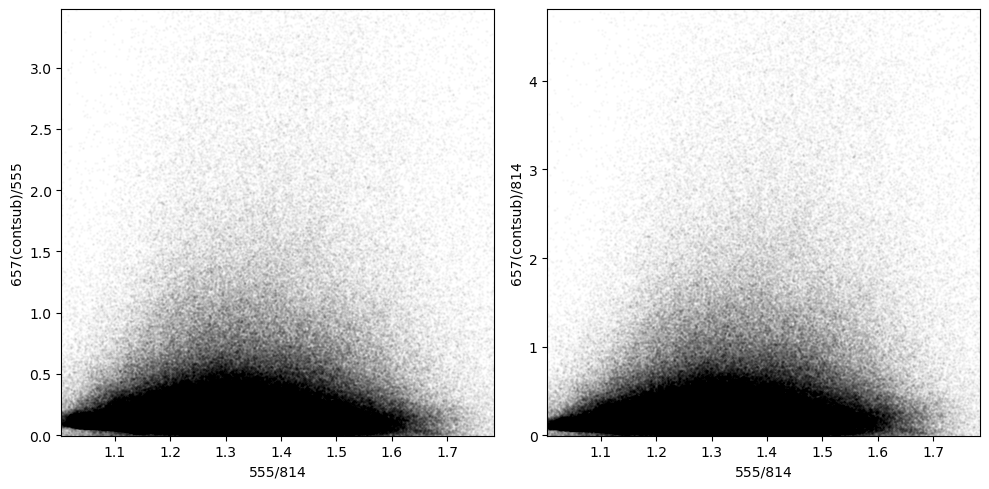

In [50]:
from scipy.stats import kde

fig = plt.figure(figsize=(10, 5))
ax1 = fig.add_subplot(1, 2, 1)
ax2 = fig.add_subplot(1, 2, 2)

xdata = (hdu_muse_f555w.data/hdu_muse_f814w.data).flatten()
ydata1 = (hdu_muse_halpha.data/hdu_muse_f555w.data).flatten()
ydata2 = (hdu_muse_halpha.data/hdu_muse_f814w.data).flatten()

for ax, ydata in zip([ax1,ax2], [ydata1, ydata2]):

    ax.scatter(xdata, ydata, c='k', alpha=0.02, s=1, rasterized=True)
    ax.set_xlim(np.nanpercentile(xdata,[1,99]))
    ax.set_ylim(np.nanpercentile(ydata,[1,99]))

    # nbins = 100
    # xi, yi = np.mgrid[np.nanmin(xdata):np.nanmax(xdata):nbins*1j, np.nanmin(ydata):np.nanmax(ydata):nbins*1j]

    # k = kde.gaussian_kde([xdata,ydata])
    # zi = k(np.vstack([xi.flatten(), yi.flatten()]))

    ax.set_xlabel('555/814')

ax1.set_ylabel('657(contsub)/555') 
ax2.set_ylabel('657(contsub)/814')  

plt.tight_layout()

Correct units 
ergcm2sA to ergcm2s

In [22]:
def get_ergcm2sA_2_ergcm2s(hdu, photbw):

    data = hdu.data.copy()
    data_conv = data * photbw
    hdu.data = np.array(data_conv, dtype=np.float32)
    hdu.header['BUNIT'] = ('erg/s/cm2/pixel', '1e-20 erg/s/cm2')

    return(hdu)

hdu_hst_f65Xn_anf =  get_ergcm2sA_2_ergcm2s(hdu_hst_f65Xn_an, bp['%s_%s' %(instrument_f65Xn.upper(), narrowband_filter.upper())]['rectwidth'])

hdu_muse_halpha = get_ergcm2sA_2_ergcm2s(hdu_muse_halpha, bp['%s_%s' %(instrument_f65Xn.upper(), narrowband_filter.upper())]['rectwidth'])
hdu_hst_an_halpha = get_ergcm2sA_2_ergcm2s(hdu_hst_an_halpha, bp['%s_%s' %(instrument_f65Xn.upper(), narrowband_filter.upper())]['rectwidth'])
hdu_hst_halpha = get_ergcm2sA_2_ergcm2s(hdu_hst_halpha, bp['%s_%s' %(instrument_f65Xn.upper(), narrowband_filter.upper())]['rectwidth'])

hdu_muse_cont = get_ergcm2sA_2_ergcm2s(hdu_muse_cont, bp['%s_%s' %(instrument_f65Xn.upper(), narrowband_filter.upper())]['rectwidth'])
hdu_hst_an_cont = get_ergcm2sA_2_ergcm2s(hdu_hst_an_cont, bp['%s_%s' %(instrument_f65Xn.upper(), narrowband_filter.upper())]['rectwidth'])
hdu_hst_cont = get_ergcm2sA_2_ergcm2s(hdu_hst_cont, bp['%s_%s' %(instrument_f65Xn.upper(), narrowband_filter.upper())]['rectwidth'])

In [23]:
hdu_hst_f555w_smre.writeto(rootdir+'hst_contsub_bintests/hdu_hst_f555w_smre.fits', overwrite=True)
hdu_hst_f65Xn_smre.writeto(rootdir+'hst_contsub_bintests/hdu_hst_%s_smre.fits' %narrowband_filter, overwrite=True)
hdu_hst_f814w_smre.writeto(rootdir+'hst_contsub_bintests/hdu_hst_f814w_smre.fits', overwrite=True)

hdu_hst_f555w.writeto(rootdir+'hst_contsub_bintests/hdu_hst_f555w.fits', overwrite=True)
hdu_hst_f65Xn.writeto(rootdir+'hst_contsub_bintests/hdu_hst_%s.fits' %narrowband_filter, overwrite=True)
hdu_hst_f814w.writeto(rootdir+'hst_contsub_bintests/hdu_hst_f814w.fits', overwrite=True)

hdu_muse_f555w.writeto(rootdir+'hst_contsub_bintests/hdu_muse_f555w.fits', overwrite=True)
hdu_muse_f65Xn.writeto(rootdir+'hst_contsub_bintests/hdu_muse_%s.fits' %narrowband_filter, overwrite=True)
hdu_muse_f814w.writeto(rootdir+'hst_contsub_bintests/hdu_muse_f814w.fits', overwrite=True)

hdu_hst_f555w_an.writeto(rootdir+'hst_contsub_bintests/hdu_hst_f555w_an.fits', overwrite=True)
hdu_hst_f65Xn_an.writeto(rootdir+'hst_contsub_bintests/hdu_hst_%s_an.fits' %narrowband_filter, overwrite=True)
hdu_hst_f814w_an.writeto(rootdir+'hst_contsub_bintests/hdu_hst_f814w_an.fits', overwrite=True)

hdu_hst_f65Xn_anf.writeto(rootdir+'hst_contsub_bintests/hdu_hst_%s_anf.fits' %narrowband_filter, overwrite=True)

hdu_muse_halpha.writeto(rootdir+'hst_contsub_bintests/hdu_muse_%s_contsub.fits' %narrowband_filter, overwrite=True)
hdu_hst_an_halpha.writeto(rootdir+'hst_contsub_bintests/hdu_hst_%s_an_contsub.fits' %narrowband_filter, overwrite=True)
hdu_hst_halpha.writeto(rootdir+'hst_contsub_bintests/hdu_hst_%s_contsub.fits' %narrowband_filter, overwrite=True)

hdu_muse_cont.writeto(rootdir+'hst_contsub_bintests/hdu_muse_%s_cont.fits' %narrowband_filter, overwrite=True)
hdu_hst_an_cont.writeto(rootdir+'hst_contsub_bintests/hdu_hst_%s_an_cont.fits' %narrowband_filter, overwrite=True)
hdu_hst_cont.writeto(rootdir+'hst_contsub_bintests/hdu_hst_%s_cont.fits' %narrowband_filter, overwrite=True)

hdu_muse['HA6562_FLUX'].writeto(rootdir+'hst_contsub_bintests/hdu_muse_ha.fits', overwrite=True)